## Physics-aware Gradient

In [1]:
"""
Generate synthetic data and approximate gradients
"""
%matplotlib inline


import sys

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np


### Generate 2D plot

([], <a list of 0 Text yticklabel objects>)

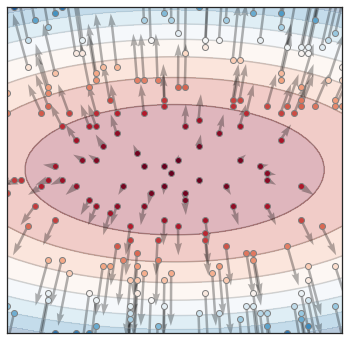

In [52]:
from utils import normalize_vector, get_projection, edge_to_directional_vector
from utils import sample_edges, sample_xy


#### A function on 2D space
class CustomFunction():
    def __init__(self, func, derivative):
        '''
        Both func and derivative are functions read (x,y) to return
        scalar value / vector value (x, y direction), respectively.
        '''
        self.func = func
        self.derivative = derivative
    
    def __call__(self, xx, yy):
        return self.func(xx, yy)
        
    def get_derivative(self, xx, yy):
        return self.derivative(xx, yy)
    
    def get_directional_derivative(self, xx, yy, directions):
        dx, dy = self.get_derivative(xx, yy)
        dxdy = np.array([dx, dy])
        if len(dxdy.shape) == 2:
            dxdy = dxdy.transpose()
        elif len(dxdy.shape) == 1:
            dxdy = dxdy.reshape(1,-1)

        ret = []
        for _dxdy, direction in zip(dxdy, directions):
            ret.append(get_projection([_dxdy[0], _dxdy[1]], direction))
        return np.array(ret)

def custom_func(xx, yy):
    '''return a function on 2D space'''
    return (0.1*xx**2 + 0.5*yy**2)
#     return (np.sin(xx) + np.cos(yy))

def custom_derivative(xx, yy):
    return 0.1*2*xx, 0.5*2*yy
#     return np.cos(xx), -np.sin(yy)        
        
def plot_points(ax, x_coord, y_coord, values, norm, cmap):
    for xc, yc, c in zip(x_coord, y_coord, values):
        ax.plot(xc, yc, 'o', c=cmap(norm(c)), markeredgecolor='gray')
        
def plot_arrows(ax, x_coord, y_coord, U, V, scale=100):
    for xc, yc, u, v in zip(x_coord, y_coord, U, V):
        ax.quiver(xc, yc, u, v, scale=scale, linewidth=0.01, alpha=0.3)
        


nx, ny = (50, 50)
x = np.linspace(-5.0, 5.0, nx)
y = np.linspace(-5.0, 5.0, ny)
xx, yy = np.meshgrid(x, y)
nb_nodes = 200
x_coord, y_coord = sample_xy(xx, yy, nb_points=nb_nodes)

F = CustomFunction(custom_func, custom_derivative)
z = F(xx, yy)
dx, dy = F.get_derivative(x_coord, y_coord)


fig, ax = plt.subplots(figsize=(6,6))
im = ax.contour(x, y, z, 8, cmap='gray', alpha=0.3);
im = ax.contourf(x, y, z, 8, cmap='RdBu', alpha=0.3);

values = F(x_coord, y_coord)
plot_points(ax, x_coord, y_coord, values, norm=im.norm, cmap=im.cmap)
plot_arrows(ax, x_coord, y_coord, dx, dy, scale=20)

plt.xticks([], [])
plt.yticks([], [])

# fig.savefig("img/xx2-yy2-arrows.pdf", bbox_inches='tight')
# fig.savefig("img/sin-cos-arrows.pdf", bbox_inches='tight')

### Build Graph

# edges: 972


([], <a list of 0 Text yticklabel objects>)

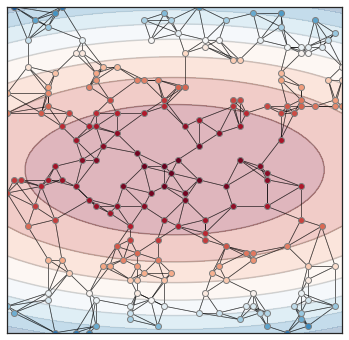

In [65]:
from utils import *

X_coord = np.vstack([x_coord, y_coord]).transpose()    # (#points, 2)

A_dense, adj_dict, start_pts, end_pts = get_graph(X_coord, num_neighbors=4, one_component=False)
edge_index = np.stack([np.array(indices, dtype=np.long) for indices in np.nonzero(A_dense)])
_, tmp = edge_to_directional_vector(edge_index, X_coord)
edge_attr = np.linalg.norm(tmp, ord=2, axis=1)


nb_edges = edge_index.shape[1]
print("# edges: {}".format(nb_edges))

fig, ax = plt.subplots(figsize=(6,6))

im = ax.contour(x, y, z, 8, cmap='gray', alpha=0.3)
im = ax.contourf(x, y, z, 8, cmap='RdBu', alpha=0.3);

values = F(x_coord, y_coord)
plot_points(ax, x_coord, y_coord, values, norm=im.norm, cmap=im.cmap)

for spt, ept in zip(start_pts, end_pts):
    ax.plot([spt[0], ept[0]], [spt[1], ept[1]], 'k-', linewidth=0.7, alpha=0.5, zorder=1)

plt.xticks([], [])
plt.yticks([], [])

### Data generation

In [66]:
tr_edges, tr_indices = sample_edges(edge_index, int(nb_edges*0.7))    # (2, #samples)

#### tr_edges are used as a training set
tr_xc, tr_direc = edge_to_directional_vector(tr_edges, X_coord)
tr_gradients = F.get_directional_derivative(tr_xc[:,0], tr_xc[:,1], tr_direc)    # target of training

#### Left edges are used as a validation and testing set
te_edge_indices = set(range(nb_edges)).difference(set(tr_indices))
te_edge_indices = np.array(list(te_edge_indices))
val_edge_indices = te_edge_indices[:int(nb_edges*0.1)]
te_edge_indices = te_edge_indices[int(nb_edges*0.1):]

val_edges = edge_index[:, val_edge_indices]
te_edges = edge_index[:, te_edge_indices]
val_xc, val_direc = edge_to_directional_vector(val_edges, X_coord)
te_xc, te_direc = edge_to_directional_vector(te_edges, X_coord)
val_gradients = F.get_directional_derivative(val_xc[:,0], val_xc[:,1], val_direc)    # target of testing
te_gradients = F.get_directional_derivative(te_xc[:,0], te_xc[:,1], te_direc)    # target of testing


values = F(x_coord, y_coord)
X = np.concatenate([X_coord, values.reshape(-1,1)], axis=1)    # (#points, 3)

print("# edges in training set: {}".format(tr_edges.shape[1]))
print("# edges in validation set: {}".format(val_edges.shape[1]))
print("# edges in testing set: {}".format(te_edges.shape[1]))

# edges in training set: 680
# edges in validation set: 97
# edges in testing set: 195


### Baselines

In [67]:
"""
Standard operator (No learnable parameters)
"""
def standard_gradient(x_i, x_j, func):
    """
    (f_j - f_i) / ||x_j - x_i||
    """
    nominator = func(x_j[0], x_j[1]) - func(x_i[0], x_i[1])
    h = np.linalg.norm(x_j - x_i, ord=2)
    if h==0:
        h=np.finfo(v.dtype).eps
    return nominator/h


tr_ret = []
for _edge in tr_edges.transpose():
    sender, receiver = _edge[0], _edge[1]
    
    tr_ret.append(standard_gradient(X_coord[sender], X_coord[receiver], F.func))
tr_ret = np.array(tr_ret)
tr_mse = ((tr_ret - tr_gradients)**2).mean()

val_ret = []
for _edge in val_edges.transpose():
    sender, receiver = _edge[0], _edge[1]
    
    val_ret.append(standard_gradient(X_coord[sender], X_coord[receiver], F.func))
val_ret = np.array(val_ret)
val_mse = ((val_ret - val_gradients)**2).mean()

te_ret = []
for _edge in te_edges.transpose():
    sender, receiver = _edge[0], _edge[1]
    
    te_ret.append(standard_gradient(X_coord[sender], X_coord[receiver], F.func))
te_ret = np.array(te_ret)
te_mse = ((te_ret - te_gradients)**2).mean()

print("[Training] Standard operator MSE: {:.4e}".format(tr_mse))
print("[Valid] Standard operator MSE: {:.4e}".format(val_mse))
print("[Test] Standard operator MSE: {:.4e}".format(te_mse))

[Training] Standard operator MSE: 5.0652e-02
[Valid] Standard operator MSE: 4.9709e-02
[Test] Standard operator MSE: 6.2760e-02


In [68]:
"""
MLP - Using only two points
"""
import torch.nn as nn
import torch.optim as optim


#### training
X_tr_mlp_two_pts = []
for _edge in tr_edges.transpose():
    s_coord, r_coord, s_value, r_value = edge_to_two_points(_edge, F, X_coord)
    tmp = s_coord.tolist() + r_coord.tolist()
    tmp.append(s_value)
    tmp.append(r_value)
    X_tr_mlp_two_pts.append(tmp)

#### validation
X_val_mlp_two_pts = []
for _edge in val_edges.transpose():
    s_coord, r_coord, s_value, r_value = edge_to_two_points(_edge, F, X_coord)
    tmp = s_coord.tolist() + r_coord.tolist()
    tmp.append(s_value)
    tmp.append(r_value)
    X_val_mlp_two_pts.append(tmp)

#### test    
X_te_mlp_two_pts = []
for _edge in te_edges.transpose():
    s_coord, r_coord, s_value, r_value = edge_to_two_points(_edge, F, X_coord)
    tmp = s_coord.tolist() + r_coord.tolist()
    tmp.append(s_value)
    tmp.append(r_value)
    X_te_mlp_two_pts.append(tmp)

    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


X_tr_mlp_two_pts = np.array(X_tr_mlp_two_pts)    # (#edges, 2+2+1+1)
X_tr_mlp_two_pts = torch.tensor(X_tr_mlp_two_pts, dtype=torch.float32, device=device)
# tr_tmp = torch.tensor([np.linalg.norm([x[2].item()-x[0].item(), x[3].item()-x[1].item()], ord=2) for x in X_tr_mlp_two_pts], device=device)
# X_tr_mlp_two_pts = torch.cat((X_tr_mlp_two_pts, tr_tmp.unsqueeze(1)), 1)
y_tr_gradients = torch.tensor(tr_gradients, dtype=torch.float32, device=device)
nb_train = X_tr_mlp_two_pts.shape[0]

X_val_mlp_two_pts = np.array(X_val_mlp_two_pts)    # (#edges, 2+2+1+1)
X_val_mlp_two_pts = torch.tensor(X_val_mlp_two_pts, dtype=torch.float32, device=device)
# val_tmp = torch.tensor([np.linalg.norm([x[2].item()-x[0].item(), x[3].item()-x[1].item()], ord=2) for x in X_val_mlp_two_pts], device=device)
# X_val_mlp_two_pts = torch.cat((X_val_mlp_two_pts, val_tmp.unsqueeze(1)), 1)
y_val_gradients = torch.tensor(val_gradients, dtype=torch.float32, device=device)
nb_valid = X_val_mlp_two_pts.shape[0]

X_te_mlp_two_pts = np.array(X_te_mlp_two_pts)    # (#edges, 2+2+1+1)
X_te_mlp_two_pts = torch.tensor(X_te_mlp_two_pts, dtype=torch.float32, device=device)
# te_tmp = torch.tensor([np.linalg.norm([x[2].item()-x[0].item(), x[3].item()-x[1].item()], ord=2) for x in X_te_mlp_two_pts], device=device)
# X_te_mlp_two_pts = torch.cat((X_te_mlp_two_pts, te_tmp.unsqueeze(1)), 1)
y_te_gradients = torch.tensor(te_gradients, dtype=torch.float32, device=device)
nb_test = X_te_mlp_two_pts.shape[0]



# ##### MLP method #####
input_size = X_tr_mlp_two_pts.shape[1]
# input_size = 3
LATENT_SIZE = 64
output_size = 1
net1 = nn.Sequential(nn.Linear(input_size, LATENT_SIZE),
                     nn.ReLU(),
                     nn.Linear(LATENT_SIZE, LATENT_SIZE),
                     nn.ReLU(),
                     nn.Linear(LATENT_SIZE, output_size))


#### Optimizer
optimizer = optim.Adam(net1.parameters(), lr=0.001, weight_decay=5e-4)
val_losses = []
min_val_loss = np.float("inf")
net1.to(device)
net1.train()
EPOCHS = 1000
used_timestamps = []
batch_size = 16

for ii in range(EPOCHS):
    
    for _ in range(int(nb_train/batch_size)):
        _indices = np.random.randint(nb_train, size=batch_size)

        pred = net1(X_tr_mlp_two_pts[_indices,:])    # (#edges, #features) -> (#edges, 1)

        loss = torch.mean((pred.squeeze() - y_tr_gradients[_indices])**2)

        #### Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if ii%50 == 0:
        with torch.no_grad():
            val_loss = torch.mean((net1(X_val_mlp_two_pts).squeeze() - y_val_gradients)**2).item()

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(net1, './model-approx-gradient/mlp_two_points')
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}\t[Saved]".format(ii+1, EPOCHS, loss.item(), val_loss))
            else:
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}".format(ii+1, EPOCHS, loss.item(), val_loss))


net1 = torch.load('./model-approx-gradient/mlp_two_points')
with torch.no_grad():
    te_loss = torch.mean((net1(X_te_mlp_two_pts).squeeze() - y_te_gradients)**2).item()
print(" ")
print("[Test]MSE : {:.4e}".format(te_loss))

MSE at 1/1000	[Train]: 2.1983e+00	[Valid]: 3.1183e+00	[Saved]
MSE at 51/1000	[Train]: 4.5134e-01	[Valid]: 2.8688e-01	[Saved]
MSE at 101/1000	[Train]: 3.4645e-01	[Valid]: 2.3782e-01	[Saved]
MSE at 151/1000	[Train]: 1.6930e-01	[Valid]: 1.4439e-01	[Saved]
MSE at 201/1000	[Train]: 9.2367e-03	[Valid]: 6.9759e-02	[Saved]
MSE at 251/1000	[Train]: 4.3899e-02	[Valid]: 5.7885e-02	[Saved]
MSE at 301/1000	[Train]: 3.6593e-02	[Valid]: 4.4497e-02	[Saved]
MSE at 351/1000	[Train]: 2.5108e-02	[Valid]: 4.0663e-02	[Saved]
MSE at 401/1000	[Train]: 8.1369e-03	[Valid]: 2.9668e-02	[Saved]
MSE at 451/1000	[Train]: 1.6773e-02	[Valid]: 2.3061e-02	[Saved]
MSE at 501/1000	[Train]: 1.2469e-02	[Valid]: 2.4621e-02
MSE at 551/1000	[Train]: 1.7218e-02	[Valid]: 3.0553e-02
MSE at 601/1000	[Train]: 7.6668e-03	[Valid]: 1.8938e-02	[Saved]
MSE at 651/1000	[Train]: 1.7333e-03	[Valid]: 2.1338e-02
MSE at 701/1000	[Train]: 1.2118e-02	[Valid]: 3.8753e-02
MSE at 751/1000	[Train]: 1.6406e-03	[Valid]: 1.4999e-02	[Saved]
MSE at 801/

In [69]:
"""
Graph Network - Using local neighbors
"""

import torch.nn as nn
import torch.optim as optim

from modules import GNConv
from blocks import EdgeBlock, NodeBlock, GlobalBlock

from torch_geometric.data import Data
from torch_scatter import scatter_add, scatter_max, scatter_mean, scatter_min, scatter_mul

from model import Net


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

node_attr_size = X.shape[1]
edge_attr_size = 1
output_size = 1
edge_hidden_size = 64
node_hidden_size = 64
global_hidden_size = 64

# X : (#nodes, 3)
if isinstance(edge_index, np.ndarray):
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
elif isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.clone().detach()
    edge_attr = edge_attr.clone().detach()

input_graph = Data(x=torch.tensor(X, dtype=torch.float32, device=device), 
                   edge_index=edge_index.to(device), edge_attr=edge_attr.unsqueeze(1).to(device))
input_graph.global_attr = torch.zeros((1, global_hidden_size), device=device)    # initial global_attr

y_tr_gradients = torch.tensor(tr_gradients, dtype=torch.float32, device=device)
y_val_gradients = torch.tensor(val_gradients, dtype=torch.float32, device=device)
y_te_gradients = torch.tensor(te_gradients, dtype=torch.float32, device=device)
    
model = Net(node_attr_size,
            edge_attr_size,
            output_size, 
            edge_hidden_size=edge_hidden_size, 
            node_hidden_size=node_hidden_size, 
            global_hidden_size=global_hidden_size,
            device=device)
model.to(device)


#### Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
min_val_loss = np.float("inf")
EPOCHS = 1000
batch_size = 16

for ii in range(EPOCHS):
    
    for _ in range(int(tr_indices.shape[0]/batch_size)):
        _indices = np.random.randint(tr_indices.shape[0], size=batch_size)
        tr_ind = tr_indices[_indices]
        
        pred = model(input_graph).edge_attr[tr_ind, :]    # (#edges, #features) -> (#edges, 1)

        loss = torch.mean((pred.squeeze() - y_tr_gradients[_indices])**2)

        #### Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if ii%50 == 0:
        with torch.no_grad():
            val_pred = model(input_graph).edge_attr[val_edge_indices]
            val_loss = torch.mean((val_pred.squeeze() - y_val_gradients)**2).item()

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(model, './model-approx-gradient/gn-1hop')
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}\t[Saved]".format(ii+1, EPOCHS, loss.item(), val_loss))
            else:
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}".format(ii+1, EPOCHS, loss.item(), val_loss))

with torch.no_grad():
    model = torch.load('./model-approx-gradient/gn-1hop')
te_pred = model(input_graph).edge_attr[te_edge_indices]
te_loss = torch.mean((te_pred.squeeze() - y_te_gradients)**2).item()
print(" ")
print("[Test]MSE : {:.4e}".format(te_loss))

MSE at 1/1000	[Train]: 2.1618e+00	[Valid]: 4.4503e+00	[Saved]
MSE at 51/1000	[Train]: 3.8160e-02	[Valid]: 1.2724e-01	[Saved]
MSE at 101/1000	[Train]: 6.1648e-02	[Valid]: 6.2114e-02	[Saved]
MSE at 151/1000	[Train]: 2.0688e-02	[Valid]: 5.1541e-02	[Saved]
MSE at 201/1000	[Train]: 5.8938e-03	[Valid]: 4.5489e-02	[Saved]
MSE at 251/1000	[Train]: 1.3182e-02	[Valid]: 5.3698e-02
MSE at 301/1000	[Train]: 3.6402e-03	[Valid]: 4.5798e-02
MSE at 351/1000	[Train]: 2.7999e-03	[Valid]: 3.2946e-02	[Saved]
MSE at 401/1000	[Train]: 5.6881e-03	[Valid]: 3.3150e-02
MSE at 451/1000	[Train]: 7.6508e-03	[Valid]: 2.2214e-02	[Saved]
MSE at 501/1000	[Train]: 4.7308e-03	[Valid]: 2.1002e-02	[Saved]
MSE at 551/1000	[Train]: 7.0147e-03	[Valid]: 3.7969e-02
MSE at 601/1000	[Train]: 8.0287e-03	[Valid]: 2.8907e-02
MSE at 651/1000	[Train]: 1.3662e-03	[Valid]: 2.9022e-02
MSE at 701/1000	[Train]: 3.4043e-03	[Valid]: 2.4505e-02
MSE at 751/1000	[Train]: 2.8388e-03	[Valid]: 1.9346e-02	[Saved]
MSE at 801/1000	[Train]: 3.3725e-03

In [71]:
"""
(grad f)_ij = w_ij*f_j - f_i form
""" 
import torch.nn as nn
import torch.optim as optim

from modules import GNConv
from blocks import EdgeBlock, NodeBlock, GlobalBlock

from torch_geometric.data import Data
from torch_scatter import scatter_add, scatter_max, scatter_mean, scatter_min, scatter_mul

from model import Net3


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

node_attr_size = X.shape[1]
edge_attr_size = 1
output_size = 1
edge_hidden_size = 64
node_hidden_size = 64
global_hidden_size = 64

# X : (#nodes, 3)
if isinstance(edge_index, np.ndarray):
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
elif isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.clone().detach()
    edge_attr = edge_attr.clone().detach()

input_graph = Data(x=torch.tensor(X, dtype=torch.float32, device=device), 
                   edge_index=edge_index.to(device), edge_attr=edge_attr.unsqueeze(1).to(device))
input_graph.global_attr = torch.zeros((1, global_hidden_size), device=device)    # initial global_attr

y_tr_gradients = torch.tensor(tr_gradients, dtype=torch.float32, device=device)
y_val_gradients = torch.tensor(val_gradients, dtype=torch.float32, device=device)
y_te_gradients = torch.tensor(te_gradients, dtype=torch.float32, device=device)

model = Net3(node_attr_size,
             edge_attr_size,
             output_size, 
             edge_hidden_size=edge_hidden_size, 
             node_hidden_size=node_hidden_size, 
             global_hidden_size=global_hidden_size,
             device=device)
model.to(device)


#### Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
min_val_loss = np.float("inf")
EPOCHS = 1000
batch_size = 16

for ii in range(EPOCHS):
    
    for _ in range(int(tr_indices.shape[0]/batch_size)):
        _indices = np.random.randint(tr_indices.shape[0], size=batch_size)
        tr_ind = tr_indices[_indices]

        pred = model(input_graph)[tr_ind]    # (#edges, 1)

        loss = torch.mean((pred.squeeze() - y_tr_gradients[_indices])**2)

        #### Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if ii%50 == 0:
        with torch.no_grad():
            val_pred = model(input_graph)[val_edge_indices]
            val_loss = torch.mean((val_pred.squeeze() - y_val_gradients)**2).item()

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(model, './model-approx-gradient/gn-1hop-one-w-form')
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}\t[Saved]".format(ii+1, EPOCHS, loss.item(), val_loss))
            else:
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}".format(ii+1, EPOCHS, loss.item(), val_loss))

with torch.no_grad():
    model = torch.load('./model-approx-gradient/gn-1hop-one-w-form')
te_pred = model(input_graph)[te_edge_indices]
te_loss = torch.mean((te_pred.squeeze() - y_te_gradients)**2).item()
print(" ")
print("[Test]MSE : {:.4e}".format(te_loss))

MSE at 1/1000	[Train]: 1.1919e+00	[Valid]: 2.6280e+00	[Saved]
MSE at 51/1000	[Train]: 1.2385e-01	[Valid]: 4.7518e-01	[Saved]
MSE at 101/1000	[Train]: 1.2256e-02	[Valid]: 8.0297e-02	[Saved]
MSE at 151/1000	[Train]: 3.7453e-02	[Valid]: 5.5487e-02	[Saved]
MSE at 201/1000	[Train]: 2.4264e-02	[Valid]: 7.6800e-02
MSE at 251/1000	[Train]: 1.8691e-02	[Valid]: 5.5166e-02	[Saved]
MSE at 301/1000	[Train]: 1.6056e-02	[Valid]: 4.2912e-02	[Saved]
MSE at 351/1000	[Train]: 1.2596e-02	[Valid]: 4.4960e-02
MSE at 401/1000	[Train]: 2.7030e-03	[Valid]: 2.9949e-02	[Saved]
MSE at 451/1000	[Train]: 3.2571e-02	[Valid]: 7.8458e-02
MSE at 501/1000	[Train]: 6.4245e-03	[Valid]: 2.8914e-02	[Saved]
MSE at 551/1000	[Train]: 2.8620e-03	[Valid]: 3.1073e-02
MSE at 601/1000	[Train]: 5.8612e-03	[Valid]: 2.9590e-02
MSE at 651/1000	[Train]: 3.4761e-03	[Valid]: 2.7018e-02	[Saved]
MSE at 701/1000	[Train]: 4.6831e-03	[Valid]: 2.9965e-02
MSE at 751/1000	[Train]: 1.4238e-02	[Valid]: 3.9238e-02
MSE at 801/1000	[Train]: 1.1691e-02

In [70]:
"""
(grad f)_ij = w1_ij*(f_j - w2_ij*f_i) form
"""
import torch.nn as nn
import torch.optim as optim

from modules import GNConv
from blocks import EdgeBlock, NodeBlock, GlobalBlock

from torch_geometric.data import Data
from torch_scatter import scatter_add, scatter_max, scatter_mean, scatter_min, scatter_mul

from model import Net4


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

node_attr_size = X.shape[1]
edge_attr_size = 1
output_size = 1
edge_hidden_size = 64
node_hidden_size = 64
global_hidden_size = 64

# X : (#nodes, 3)
if isinstance(edge_index, np.ndarray):
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
elif isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.clone().detach()
    edge_attr = edge_attr.clone().detach()

input_graph = Data(x=torch.tensor(X, dtype=torch.float32, device=device), 
                   edge_index=edge_index.to(device), edge_attr=edge_attr.unsqueeze(1).to(device))
input_graph.global_attr = torch.zeros((1, global_hidden_size), device=device)    # initial global_attr

y_tr_gradients = torch.tensor(tr_gradients, dtype=torch.float32, device=device)
y_val_gradients = torch.tensor(val_gradients, dtype=torch.float32, device=device)
y_te_gradients = torch.tensor(te_gradients, dtype=torch.float32, device=device)

model = Net4(node_attr_size,
             edge_attr_size,
             output_size, 
             edge_hidden_size=edge_hidden_size, 
             node_hidden_size=node_hidden_size, 
             global_hidden_size=global_hidden_size,
             device=device)
model.to(device)


#### Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
min_val_loss = np.float("inf")
EPOCHS = 1000
batch_size = 16

for ii in range(EPOCHS):
    
    for _ in range(int(tr_indices.shape[0]/batch_size)):
        _indices = np.random.randint(tr_indices.shape[0], size=batch_size)
        tr_ind = tr_indices[_indices]

        pred = model(input_graph)[tr_ind]    # (#edges, 1)

        loss = torch.mean((pred.squeeze() - y_tr_gradients[_indices])**2)

        #### Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if ii%50 == 0:
        with torch.no_grad():
            val_pred = model(input_graph)[val_edge_indices]
            val_loss = torch.mean((val_pred.squeeze() - y_val_gradients)**2).item()

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(model, './model-approx-gradient/gn-1hop-two-w-form')
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}\t[Saved]".format(ii+1, EPOCHS, loss.item(), val_loss))
            else:
                print("MSE at {}/{}\t[Train]: {:.4e}\t[Valid]: {:.4e}".format(ii+1, EPOCHS, loss.item(), val_loss))

with torch.no_grad():
    model = torch.load('./model-approx-gradient/gn-1hop-two-w-form')
te_pred = model(input_graph)[te_edge_indices]
te_loss = torch.mean((te_pred.squeeze() - y_te_gradients)**2).item()
print(" ")
print("[Test]MSE : {:.4e}".format(te_loss))

MSE at 1/1000	[Train]: 4.5791e+00	[Valid]: 4.1230e+00	[Saved]
MSE at 51/1000	[Train]: 2.5584e-02	[Valid]: 6.0351e-02	[Saved]
MSE at 101/1000	[Train]: 1.6183e-02	[Valid]: 3.8381e-02	[Saved]
MSE at 151/1000	[Train]: 4.1177e-03	[Valid]: 4.1462e-02
MSE at 201/1000	[Train]: 6.9469e-02	[Valid]: 8.4336e-02
MSE at 251/1000	[Train]: 9.7631e-03	[Valid]: 2.1105e-02	[Saved]
MSE at 301/1000	[Train]: 3.3922e-02	[Valid]: 8.9052e-02
MSE at 351/1000	[Train]: 4.9710e-02	[Valid]: 2.3609e-02
MSE at 401/1000	[Train]: 1.9353e-02	[Valid]: 2.6646e-02
MSE at 451/1000	[Train]: 1.1795e-02	[Valid]: 1.7660e-02	[Saved]
MSE at 501/1000	[Train]: 5.1357e-03	[Valid]: 1.3275e-02	[Saved]
MSE at 551/1000	[Train]: 6.2332e-03	[Valid]: 1.0767e-02	[Saved]
MSE at 601/1000	[Train]: 3.5455e-03	[Valid]: 1.2238e-02
MSE at 651/1000	[Train]: 1.6771e-02	[Valid]: 2.2669e-02
MSE at 701/1000	[Train]: 5.5435e-03	[Valid]: 1.3703e-02
MSE at 751/1000	[Train]: 4.6181e-03	[Valid]: 1.3339e-02
MSE at 801/1000	[Train]: 6.2066e-03	[Valid]: 8.5683